# LAB 4 - GLM - Logistic regression model 


In [2]:
# Import of used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Import of the dataset
df = pd.read_csv("framingham-2.csv")
df.dropna() # As per course requirements, we are keeping it simple
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


## 1 - Response Var. TenYearCHD

is *TenYearCHD* it unbalanced?
**Yes**, it is unbalanced as no CHD outnumbers the CHD class

TenYearCHD
0    3594
1     644
Name: count, dtype: int64


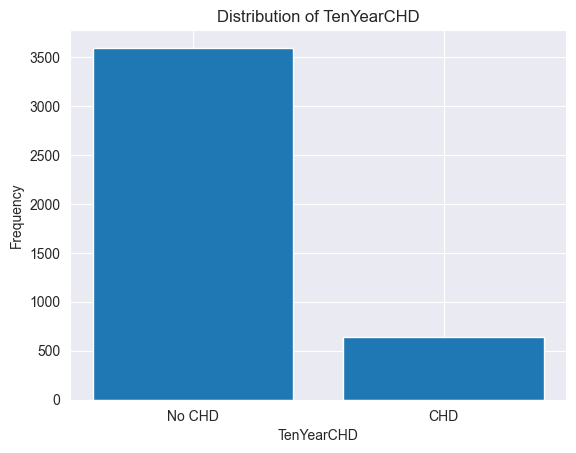

In [5]:
# a. Is it unbalanced?
class_distribution = df['TenYearCHD'].value_counts()
print(class_distribution)

# Visualize the distribution
plt.bar(class_distribution.index.map(str), class_distribution.values)
plt.xlabel('TenYearCHD')
plt.ylabel('Frequency')
plt.title('Distribution of TenYearCHD')
plt.xticks([0, 1], ['No CHD', 'CHD'])
plt.show()

- a. What are the implications of unbalanced data?
Bias, the linear regression will be biased with cases without C
- b. By Upsampling 

In [133]:
# C. - First Step Upsampling
from sklearn.utils import resample

df = df.dropna(subset=['age', 'sysBP', 'cigsPerDay', 'glucose', 'TenYearCHD'])

response_count = df.groupby("TenYearCHD")["TenYearCHD"].count()
print("==Before upsampling==")
print(response_count)

# Model Evaluation - Undersampling
df_minority = df[(df['TenYearCHD']==1)]
df_majority = df[(df['TenYearCHD']==0)]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=response_count[0], random_state=42)
df_minority_upsampled.reset_index(drop=True, inplace=True)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])
response_count = df_upsampled.groupby("TenYearCHD")["TenYearCHD"].count()
print("==After upsampling==")
print(response_count)

==Before upsampling==
TenYearCHD
0    3233
1     592
Name: TenYearCHD, dtype: int64
==After upsampling==
TenYearCHD
0    3233
1    3233
Name: TenYearCHD, dtype: int64


In [85]:
# Second Step let's find values that are useful
from statsmodels.formula.api import glm
import statsmodels.api as sm
import scipy

formula_all = 'TenYearCHD ~ C(male) + age + C(education) + C(currentSmoker) + cigsPerDay + C(BPMeds) + C(prevalentStroke) + C(prevalentHyp) + C(diabetes) + totChol + sysBP + diaBP + BMI + heartRate + glucose'

# Fitting a GLM model with a binomial family
model = glm(formula=formula_all, data=df_upsampled, family=sm.families.Binomial()).fit()


# Evaluate model adequacy
# Checking AIC and deviance for a start
print(f"AIC: {model.aic}")
print(f"Null Deviance: {model.null_deviance}, Residual Deviance: {model.deviance}")
p_value_all = 1 - scipy.stats.chi2.cdf(model.deviance, model.df_resid)
print(f"P value: {p_value_all}")
model.summary()

AIC: 7344.2045884065665
Null Deviance: 8523.933552398415, Residual Deviance: 7308.204588406567
P value: 0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6149
Model:                            GLM   Df Residuals:                     6131
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3654.1
Date:                Thu, 21 Mar 2024   Deviance:                       7308.2
Time:                        13:12:51   Pearson chi2:                 6.15e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1794
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -7.2371      0.419    -17.292      0.000      -8.057      -6.417
C(male)[T.1]                0.5064      0.062      8.179      0.000       0.385       0.628
C(education)[T.2.0]        -0.2227      0.071     -3.153      0.002      -0.361      -0.084
C(education)[T.3.0]        -0.2361      0.085     -2.783      0.005      -0.402      -0.070
C(education)[T.4.0]        -0.0757      0.093     -0.810      0.418      -0.259       0.108
C(currentSmoker)[T.1]       0.1961      0.093      2.109      0.035       0.014       0.378
C(BPMeds)[T.1.0]            0.1000      0.158      0.633      0.526      -0.209       0.409
C(prevalentStroke)[T.1]     0.7897      0.336      2.353      0.019       0.132       1.448
C(prevalentHyp)[T.1]        0.1496      0.082      1.830      0.067      -0.011       0.310
C(diabetes)[T.1]            0.1478      0.211      0.699      0.484      -0.266       0.562
age                         0.0664      0.004     17.099      0.000       0.059       0.074
cigsPerDay                  0.0165      0.004      4.319      0.000       0.009       0.024
totChol                     0.0016      0.001      2.488      0.013       0.000       0.003
sysBP                       0.0157      0.002      6.645      0.000       0.011       0.020
diaBP                      -0.0012      0.004     -0.306      0.760      -0.009       0.006
BMI                         0.0179      0.007      2.426      0.015       0.003       0.032
heartRate                  -0.0023      0.002     -0.942      0.346      -0.007       0.003
glucose                     0.0069      0.001      4.646      0.000       0.004       0.010
===========================================================================================
"""

In [146]:
# Only significant values
formula = 'TenYearCHD ~ C(male) + age + cigsPerDay + sysBP + glucose'

# Fitting a GLM model with a binomial family
model2 = glm(formula=formula, data=df_upsampled, family=sm.families.Binomial()).fit()

# Chi2 test
p_value = 1 - scipy.stats.chi2.cdf(model2.deviance, model2.df_resid)
print(f"P value: {p_value}")

model2.summary()

P value: 0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6466
Model:                            GLM   Df Residuals:                     6460
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3871.0
Date:                Thu, 21 Mar 2024   Deviance:                       7741.9
Time:                        15:29:52   Pearson chi2:                 6.47e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1722
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.2604      0.243    -29.856      0.000      -7.737      -6.784
C(male)[T.1]     0.5056      0.058      8.719      0.000       0.392       0.619
age              0.0720      0.004     20.264      0.000       0.065       0.079
cigsPerDay       0.0225      0.002      9.238      0.000       0.018       0.027
sysBP            0.0175      0.001     13.499      0.000       0.015       0.020
glucose          0.0081      0.001      7.397      0.000       0.006       0.010
================================================================================
"""

In [147]:
# Quasi binomial model to check for overdispersion
model3 = glm(formula=formula, data=df_upsampled, family=sm.families.Binomial()).fit(scale="X2")

# let's check scale and Deviance/DfResiduals
print(f"Scale: {model3.scale}")
print(f"Deviance/DfResiduals: {model3.deviance / model3.df_resid}")
model3.summary()

Scale: 1.0020371043757141
Deviance/DfResiduals: 1.198443671697574


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6466
Model:                            GLM   Df Residuals:                     6460
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0020
Method:                          IRLS   Log-Likelihood:                -3871.0
Date:                Thu, 21 Mar 2024   Deviance:                       7741.9
Time:                        15:29:54   Pearson chi2:                 6.47e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1722
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.2604      0.243    -29.826      0.000      -7.737      -6.783
C(male)[T.1]     0.5056      0.058      8.710      0.000       0.392       0.619
age              0.0720      0.004     20.244      0.000       0.065       0.079
cigsPerDay       0.0225      0.002      9.229      0.000       0.018       0.027
sysBP            0.0175      0.001     13.485      0.000       0.015       0.020
glucose          0.0081      0.001      7.390      0.000       0.006       0.010
================================================================================
"""

## 2 - Model training

70% for training and remaining 30% to calculate accuracy, sensitivity and specificity of the model.

- **Accuracy** measures the proportion of true results (both true positives and true negatives) among the total number of cases examined. A higher accuracy indicates a model that correctly predicts both classes well.
- **Sensitivity** (Recall) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of people with CHD who are correctly identified by the model). High sensitivity is crucial for medical screenings or conditions where missing a positive case (false negative) can be dangerous.
- **Specificity** measures the proportion of actual negatives that are correctly identified (e.g., the percentage of healthy people who are correctly identified by the model). High specificity is essential in situations where falsely identifying a condition (false positive) can lead to unnecessary anxiety or treatment.

In [148]:
# 70 - 30 split
from sklearn.model_selection import train_test_split

X = df_upsampled[['age', 'sysBP', 'cigsPerDay', 'glucose', 'male']] # Predictor
y = df_upsampled['TenYearCHD'] # Response

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
df_train = pd.concat([X_train, y_train], axis = 1)

model_ev = glm(formula=formula, data=df_train, family=sm.families.Binomial()).fit()
y_pred = model_ev.predict(X_test)
y_pred_nominal = np.where(y_pred < 0.5, 0, 1)

...

Accuracy: 0.6747422680412372
Sensitivity (Recall): 0.6609485368314834
Specificity: 0.6891464699683878


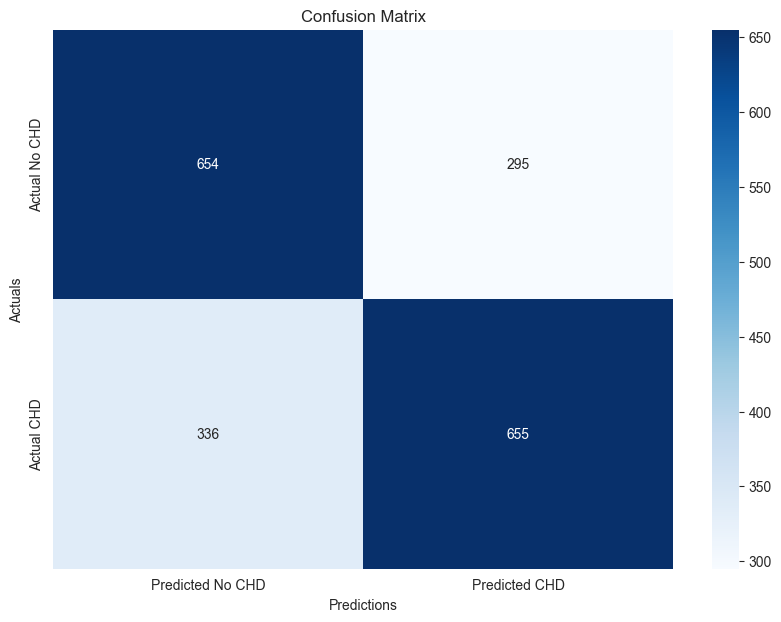

In [149]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_nominal)
print(f"Accuracy: {accuracy}")

# Calculate sensitivity and specificity
cm = confusion_matrix(y_test, y_pred_nominal)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")

## Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted No CHD', 'Predicted CHD'], yticklabels=['Actual No CHD', 'Actual CHD'])
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

Accuracy of this model is $0.67\%$


## 3 - PCA for Model Training

...

=== PCA Model Evaluation ===
Accuracy: 0.6809278350515464
Sensitivity (Recall): 0.6649848637739657
Specificity: 0.6975763962065332


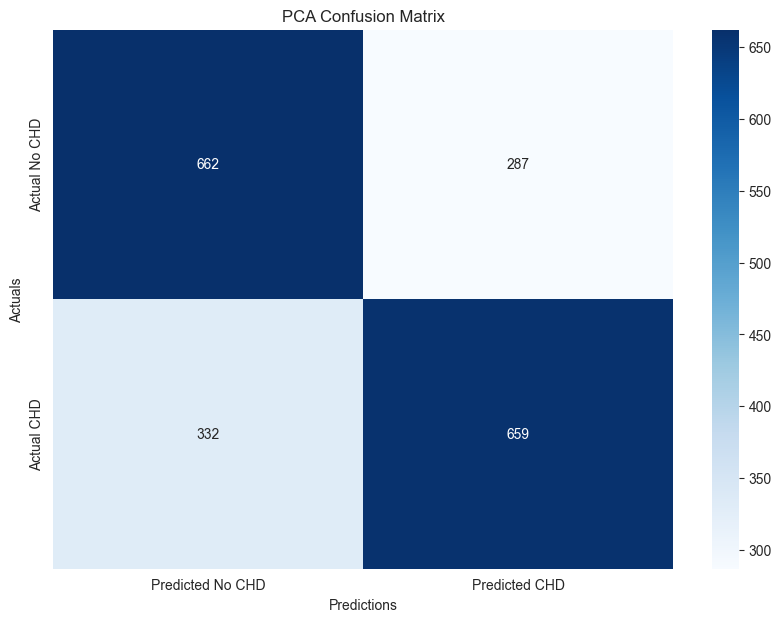

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3)) # Adjust n_components based on variance explained
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

# Train the model using GLM with PCA components
model_pca = LogisticRegression(max_iter=10000)
model_pca.fit(X_train_pca, y_train)

# Predict using the model with PCA components
y_pred_pca = model_pca.predict(X_test_pca)

# Calculate accuracy, sensitivity, and specificity
accuracy_pca = accuracy_score(y_test, y_pred_pca)
cm_pca = confusion_matrix(y_test, y_pred_pca)
tn_pca, fp_pca, fn_pca, tp_pca = cm_pca.ravel()
sensitivity_pca = tp_pca / (tp_pca + fn_pca)
specificity_pca = tn_pca / (tn_pca + fp_pca)

print("=== PCA Model Evaluation ===")
print(f"Accuracy: {accuracy_pca}")
print(f"Sensitivity (Recall): {sensitivity_pca}")
print(f"Specificity: {specificity_pca}")

# Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm_pca, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted No CHD', 'Predicted CHD'], yticklabels=['Actual No CHD', 'Actual CHD'])
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('PCA Confusion Matrix')
plt.show()
